This notebook contains the code to generate the plots shown in the paper. It assumes the experiments were run as described on GitHub, and the result are stored in /experiments.

In [268]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [300]:
experiment_name = "OU_anisotropic"
run_names = ['ritz','pinn','rel']

In [ ]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df['run_name'] = run_name
    df.dropna(how='all', inplace=True)
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 500
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            #.transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            .transform(lambda x: x.apply(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean()))
        )

print(df.columns)


/tmp/ipykernel_2620664/2930287824.py:17: RuntimeWarning: divide by zero encountered in log
  .transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))


Index(['itr', 'iteration_time', 'loss', 'main_loss', 'orth_loss', 'eigf_error',
       'grad_log_eigf_error', 'run_name', 'time', 'loss_EMA', 'main_loss_EMA',
       'orth_loss_EMA', 'eigf_error_EMA', 'grad_log_eigf_error_EMA'],
      dtype='object')


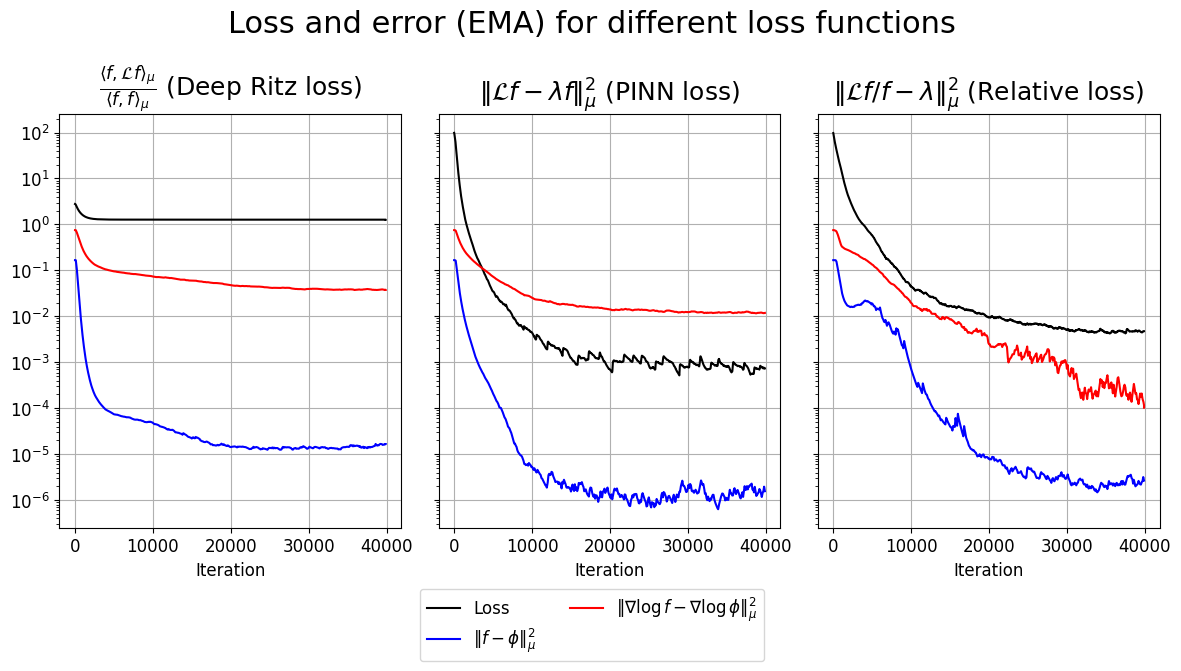

In [326]:
with plt.rc_context({'font.size': 12}):
    fig, axes = plt.subplots(1, 3, figsize=(12,6),sharey=True,sharex=True)  # 1 row, 2 columns

    index = 'itr'
    labels = {
        'ritz': r'$\frac{\langle f, \mathcal{L}f\rangle_\mu}{\langle f, f\rangle_\mu}$ (Deep Ritz loss)',
        'pinn': r'$\|\mathcal{L}f-\lambda f\|_\mu^2$ (PINN loss)',
        'rel': r'$\|\mathcal{L}f/f-\lambda\|_\mu^2$ (Relative loss)',
    }

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        run_df.plot(x=index,y='loss_EMA', color='black', ax = axes[i],label='Loss')
        run_df.plot(x=index,y='eigf_error_EMA', color='blue', ax = axes[i],label=r"$\|f-\phi\|_{\mu}^2$")
        run_df.plot(x=index,y='grad_log_eigf_error_EMA', color='red', ax = axes[i],label=r"$\|\nabla\log f-\nabla \log\phi\|_{\mu}^2$")

        #ax[i].set_title("$\|f-\phi\|_{\mu}^2$")
        axes[i].set_title(labels[run_names[i]],fontsize=18)
        axes[i].set_yscale('log')
        axes[i].grid()
        axes[i].set_xlabel('Time (s)' if index=="time" else "Iteration")
        #axes[i].set_xlim(0,20000)

    for ax in axes:
        ax.legend().set_visible(False)

    # Create shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.12))
    plt.suptitle('Loss and error (EMA) for different loss functions',fontsize=22)

    plt.tight_layout()
    plt.show()